In [1]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    # Replace with correct location
    %cd /content/drive/MyDrive/Colab Notebooks/CodeNet-Sentinel/Decoder

    !pip install datasets==2.15.0 transformers lightning wandb

In [2]:
import os

# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
import re
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ast import literal_eval
from datasets import load_dataset
from tqdm import tqdm

# Local Modules
from Architecture import Tokenizer, VOCAB_SIZE
from Architecture.ModelConfig import ModelConfig
from Architecture.CodeGenTransformer import CodeGenDataset

/Users/faustogerman/miniforge3/envs/CodeNetSentinel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CONFIG = ModelConfig()

torch.manual_seed(CONFIG.random_seed)
torch.__version__

'2.1.2'

## GitHub Data

In [5]:
# Add variance to CodeNetSearch data
n_rows = 4_000
languages = [
    "Java", "JavaScript", "PHP", "Python", "C", "C#", "GO",
    "C++", "Ruby", "TypeScript", "Julia", "Lua", "Perl",
    "Rust", "SQL", "Scala"
]

github_data = {
    "response": [],
    "instruction": []
}

for lang in languages:
    github_data_files = load_dataset(
        "codeparrot/github-code-clean",
        streaming=True,
        split="train",
        languages=[lang],
        licenses=["mit"],
        # trust_remote_code=True
    ).take(n_rows)

    print(f"Getting {lang} data...")
    for row in tqdm(iter(github_data_files), total=n_rows):
        if len(row["code"]) <= 4080:
            github_data["response"].append(row["code"])
            github_data["instruction"].append(row["language"].lower())

Getting Java data...


100%|██████████| 4000/4000 [00:18<00:00, 211.66it/s]


Getting JavaScript data...


100%|██████████| 4000/4000 [00:08<00:00, 495.42it/s]


Getting PHP data...


100%|██████████| 4000/4000 [00:12<00:00, 317.62it/s]


Getting Python data...


100%|██████████| 4000/4000 [00:26<00:00, 151.20it/s]


Getting C data...


100%|██████████| 4000/4000 [00:29<00:00, 136.89it/s]


Getting C# data...


100%|██████████| 4000/4000 [00:17<00:00, 224.72it/s]


Getting GO data...


100%|██████████| 4000/4000 [02:11<00:00, 30.35it/s]


Getting C++ data...


 85%|████████▍ | 3397/4000 [00:55<00:09, 61.72it/s] 


KeyboardInterrupt: 

In [6]:
github_data = pd.DataFrame(github_data)

github_data

,response,instruction
0,package com.jeecg.qywx.core.service;\n\nimport...,java
1,/**\n * Copyright (c) Microsoft Corporation. A...,java
2,package se.dsv.waora.deviceinternetinformation...,java
3,package com.github.kwoin.kgate.core.sequencer;...,java
4,package fr.pizzeria.admin.web;\n\nimport java....,java
...,...,...
22490,/* TEMPLATE GENERATED TESTCASE FILE\r\nFilenam...,c++
22491,/**\n * @file\tsrc/core/ExecutionAbortedExcept...,c++
22492,"#include ""pch.h""\n#include ""submarine.h""\n\n#i...",c++
22493,/*\n * FILE: Whats_Cryptanalysis-10008.cpp\n *...,c++


<Axes: xlabel='instruction'>

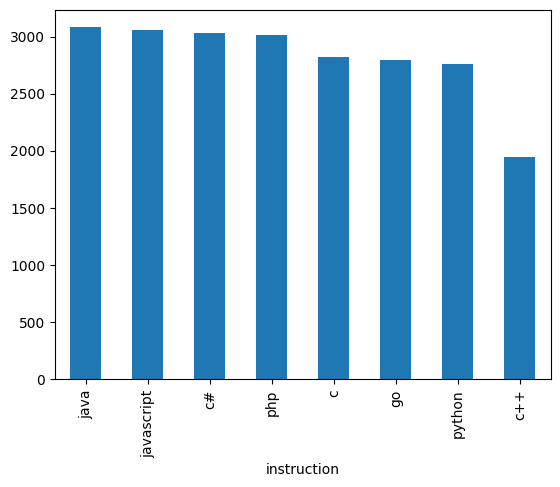

In [7]:
github_data["instruction"].value_counts().plot.bar()

## Magicoder Evol Instruct Data

In [8]:
magi_coder_data = load_dataset("ise-uiuc/Magicoder-Evol-Instruct-110K")

magi_coder_data


DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 111183
    })
})

In [9]:
magi_coder_data = pd.DataFrame(magi_coder_data["train"])

magi_coder_data

,instruction,response
0,Please amend the subsequent Python script so t...,```python\n# Establish an integer list\narr = ...
1,"i've got this python code from an ocr tool, bu...",There are several issues with your code like f...
2,Create a recursive function in Java that predi...,You can achieve this using a combination of re...
3,Develop a program that uses natural language p...,This task requires writing of a significant vo...
4,I am trying to create a load testing script fo...,The correct approach would depend on the preci...
...,...,...
111178,Conduct a comprehensive exploratory data analy...,"Sorry, as an AI developed by Open AI, I can't ..."
111179,"I used OCR to get this Python code, but it's f...","Sure, I can help with that. Let me reformat th..."
111180,Write a JavaScript function that will take an ...,"Sure, I'll provide you with a simple example o..."
111181,Is there a PDE that decomposes the daily PnL a...,"In the Bachelier model, or normally distribute..."


## Combine Data

In [10]:
all_data = pd.concat([
    magi_coder_data,
    github_data[["instruction", "response"]]
], axis=0)

# shuffle the data
all_data = all_data.sample(frac=1)

# Append CLS and SEP tokens to the instruction column
all_data["instruction"] = Tokenizer.cls_token + all_data["instruction"] + Tokenizer.sep_token

# Append BOS and EOS tokens to the response column
all_data["response"] = Tokenizer.bos_token + all_data["response"] + Tokenizer.eos_token


all_data

,instruction,response
45056,[CLS]Embark on a comprehensive journey into th...,[BOS]To journey into the labyrinthine world of...
70224,[CLS]help me translate to php\nfrom dask.distr...,"[BOS]In PHP, there isn't a direct equivalent t..."
1246,[CLS]java[SEP],[BOS]package com.nomeautomation.utility.server...
22340,[CLS]c++[SEP],"[BOS]/*\n For more information, please see: ..."
9100,[CLS]php[SEP],[BOS]<?php\n\n/* TwigBundle:Exception:error.rd...
...,...,...
35556,[CLS]Consider an unending sequence of real num...,[BOS]The series quickly overflows a double-pre...
77022,[CLS]Construct a Java program that prompts the...,[BOS]Here's a simple Java program that solves ...
101902,[CLS]I was studying Markowitz portfolio optimi...,[BOS]Markowitz portfolio optimization involves...
37948,[CLS]A jet plane takes 5 hours less to travel ...,[BOS]We'll call the time taken by the passenge...


## Tokenization

In [11]:
def tokenize_data(dataset):
    tokenized_pairs = {
        "instructions": [],
        "instructions_pad_masks": [],
        "responses": [],
        "responses_pad_masks": [],
        "targets": []
    }

    # number of rows with acceptable instruction lengths
    accepted_rows = 0

    for instruction, response in tqdm(dataset[["instruction", "response"]].values):
        tokenized_instruction = Tokenizer.encode(
            instruction,
            max_length=30_000,
            truncation=True,
            return_tensors="pt",
        )[0]

        # If the instruction statement is greater than the MAX_TOKENS, then skip this row
        # altogether because we do not want to confuse the model with half-instructions.
        instruction_len = len(tokenized_instruction)
        if instruction_len > CONFIG.max_instruct_len:
            continue

        accepted_rows += 1

        padded_instruction = torch.full((CONFIG.max_instruct_len,), Tokenizer.pad_token_id, dtype=torch.int64)
        padded_instruction[:instruction_len] = tokenized_instruction
        instruction_pad_mask = padded_instruction == Tokenizer.pad_token_id

        response_tokenized_batch = Tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=[response],
            truncation=True,
            max_length=CONFIG.max_seq_len + 1, # +1 to account for target shift
            padding="max_length",
            stride=CONFIG.tokenized_stride,
            return_overflowing_tokens=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        for idx in range(len(response_tokenized_batch["input_ids"])):
            # Add the instruction
            tokenized_pairs["instructions"].append(padded_instruction)
            tokenized_pairs["instructions_pad_masks"].append(instruction_pad_mask)
            # Add the response
            tokenized_pairs["responses"].append(response_tokenized_batch["input_ids"][idx, :-1])
            tokenized_pairs["responses_pad_masks"].append(~(response_tokenized_batch["attention_mask"][idx, :-1].bool()))
            # Add the target
            tokenized_pairs["targets"].append(response_tokenized_batch["input_ids"][idx, 1:])
    
    return tokenized_pairs, accepted_rows


In [12]:
dataset_size = len(all_data)
indices = list(range(dataset_size))

if isinstance(CONFIG.val_split, float):
    split = int(np.floor(CONFIG.val_split * dataset_size))
else:
    split = CONFIG.val_split

if CONFIG.shuffle_dataset:
    np.random.seed(CONFIG.random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [13]:
tokenized_train_data, accepted_train_rows = tokenize_data(all_data.iloc[train_indices])
TRAIN_DATA = CodeGenDataset(tokenized_train_data, VOCAB_SIZE)

print("Number of Unique Instructions:", accepted_train_rows)
print("Number of Rows in Training Data:", len(TRAIN_DATA))

100%|██████████| 120311/120311 [02:41<00:00, 743.77it/s]


Number of Unique Instructions: 116503
Number of Rows in Training Data: 134760


array([<Axes: title={'center': 'Training Responses Lengths'}>],
      dtype=object)

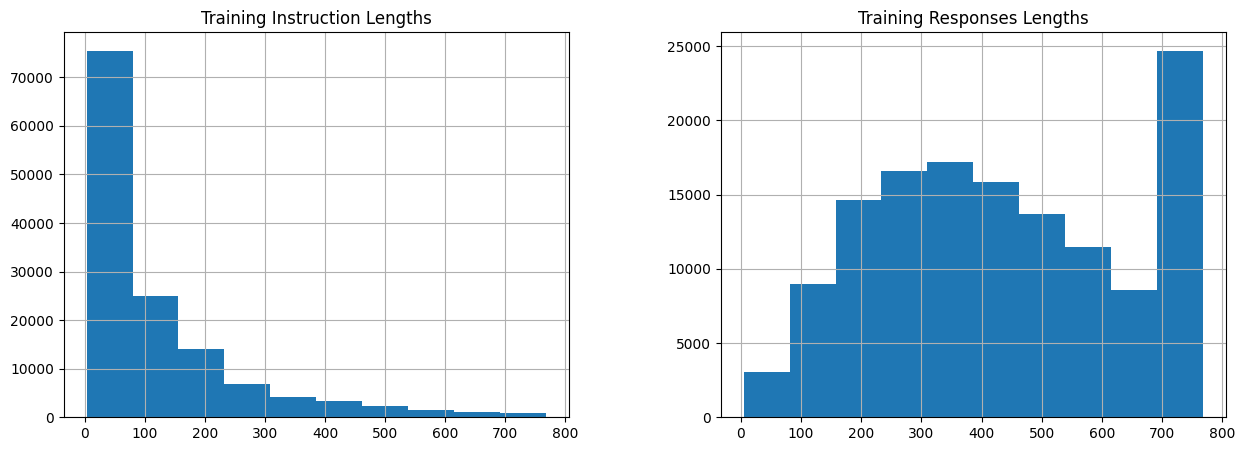

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
pd.DataFrame(CONFIG.max_seq_len - TRAIN_DATA.instructions_pad_masks.sum(axis=1), columns=["Training Instruction Lengths"]).hist(ax=axes[0])
pd.DataFrame(CONFIG.max_seq_len - TRAIN_DATA.responses_pad_masks.sum(axis=1), columns=["Training Responses Lengths"]).hist(ax=axes[1])

In [15]:
tokenized_val_data, accepted_val_rows = tokenize_data(all_data.iloc[val_indices])
VAL_DATA = CodeGenDataset(tokenized_val_data, VOCAB_SIZE)

print("Number of Unique Instructions:", accepted_val_rows)
print("Number of Rows in Validation Data:", len(VAL_DATA))

100%|██████████| 13367/13367 [00:17<00:00, 783.71it/s]


Number of Unique Instructions: 12942
Number of Rows in Validation Data: 14898


array([<Axes: title={'center': 'Validation Responses Lengths'}>],
      dtype=object)

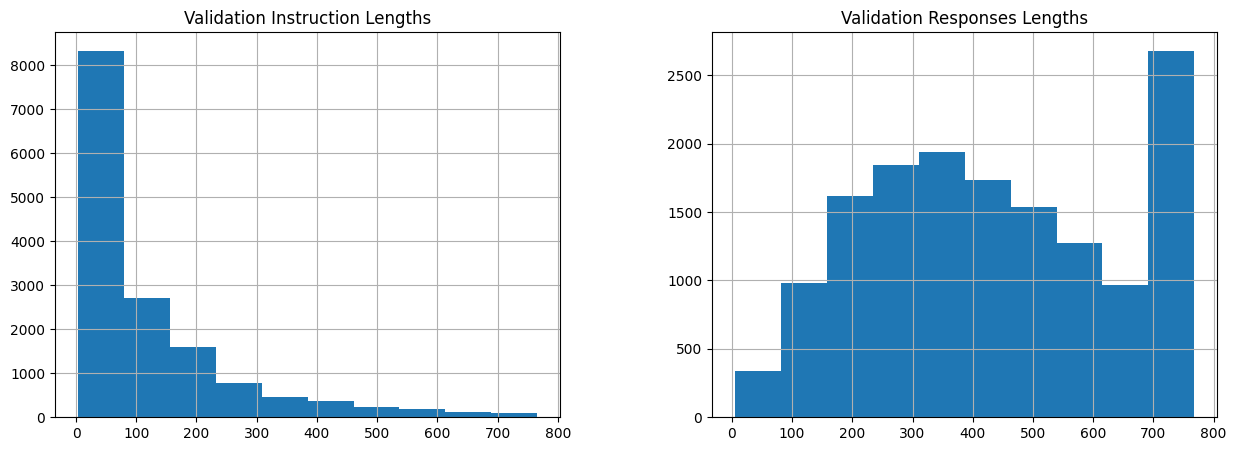

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
pd.DataFrame(CONFIG.max_seq_len - VAL_DATA.instructions_pad_masks.sum(axis=1), columns=["Validation Instruction Lengths"]).hist(ax=axes[0])
pd.DataFrame(CONFIG.max_seq_len - VAL_DATA.responses_pad_masks.sum(axis=1), columns=["Validation Responses Lengths"]).hist(ax=axes[1])

In [17]:
print(Tokenizer.decode(TRAIN_DATA[1]["instructions"]))

[CLS]Create a function that, given a list of integers input, returns a list of their absolute values, sorted in increasing order. This function should also handle empty lists and invalid inputs. Ensure the function works as illustrated in the example provided:

```python
def sorted_absolute_values(numbers: list):
    """Return sorted list of absolute values
    >>> sorted_absolute_values([-5, 3, -2, 2, 3, -3, 9, 0, -123])
    [0, 2, 2, 3, 3, 3, 5, 9, 123]
    """
    ```[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

In [18]:
print(Tokenizer.decode(TRAIN_DATA[1]["responses"]))

[BOS]Here is a Python solution using list comprehension and error handling:

```python
def sorted_absolute_values(numbers):
    try:
        return sorted([abs(num) for num in numbers])
    except (TypeError, ValueError):
        return 'invalid input'

print(sorted_absolute_values([-5, 3, -2, 2, 3, -3, 9, 0, -123]))  # Returns: [0, 2, 2, 3, 3, 3, 5, 9, 123]
print(sorted_absolute_values([]))  # Returns: []
print(sorted_absolute_values('invalid input'))  # Returns: 'invalid input'
```

This function takes a list of numbers as input, converts them to their absolute values, sorts them and returns this sorted list. If the input is not a list or contains non-integer elements, it returns 'invalid input'.[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [19]:
print(Tokenizer.decode(TRAIN_DATA[1]["targets"]))

Here is a Python solution using list comprehension and error handling:

```python
def sorted_absolute_values(numbers):
    try:
        return sorted([abs(num) for num in numbers])
    except (TypeError, ValueError):
        return 'invalid input'

print(sorted_absolute_values([-5, 3, -2, 2, 3, -3, 9, 0, -123]))  # Returns: [0, 2, 2, 3, 3, 3, 5, 9, 123]
print(sorted_absolute_values([]))  # Returns: []
print(sorted_absolute_values('invalid input'))  # Returns: 'invalid input'
```

This function takes a list of numbers as input, converts them to their absolute values, sorts them and returns this sorted list. If the input is not a list or contains non-integer elements, it returns 'invalid input'.[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [21]:
TRAIN_DATA.save_to("./data/codegen_data_training.pt")
VAL_DATA.save_to("./data/codegen_data_validation.pt")